# Modeling Language Processing: Large Language Models & their use in Predicting eye tracking features

In this tutorial we will be using language models to predict eye movements during natural reading of English sentences. This notebook is partly based on a tutorial by Nora Hollenstein taught during this year's [ESSLLI course](https://esslli2021.unibz.it/page/course/analyzing_the_cognitive_plausibility_of_deep_language_models/) on cognitive plausibility of language models. It uses eye tracking data from the [Zurich Cognitive Language Processing Corpus (ZuCo)](https://www.nature.com/articles/sdata2018291), as provided for the [CMCL 2021 Shared Task](https://cmclorg.github.io/shared_task). This tutorial was adjusted and extended for ICCN'21 by Marianne de Heer Kloots and Jelle Zuidema.

Eye-tracking data from reading represent an important resource for both linguistics and natural language processing. The ability to accurately model gaze features is a key source of information for advancing our understanding of language processing. On one hand, it can tell us how well our computational models align with human language processing mechanisms. On the other hand, it may provide more accurate models of reading to further psycholinguistic research.

**What you'll learn**: At the end of this tutorial, you will...
- have analyzed transformer-based large language models, and computed and visualized both static and contextualized embeddings
- be acquainted with eye tracking data and the structure of the ZuCo corpus
- have used transformer language models to predict eye tracking features recorded during reading (fixation duration, fixation proportion, etc.)
- have compared the performance of a pre-trained model and a model fine-tuned on eye tracking data
- evaluate and reflect on the ability of a contextualized language model to predict psycholinguistic data.

Throughout the tutoroial there are exercises for you to do. For some excercises you'll receive points, which will determine your grade (**10 points in total, 10% of the grade for the entire course**).

## Contents
1. Setup
2. Exploring the ZuCo corpus
3. Visualizing eye tracking features
3. Pre-trained language models
4. Finetuning the language model on eye-tracking data
5. Evaluating model predictions

![ICCN-CCN-figure](img/ICCN-CCN-figure.png)

In this tutorial we will look at Large Language Models from Artificial Intelligence, and eye-tracking data from cognitive science, and consider how well the models help understand the data. We will not look at neuroscience data today, but the same models and some logic is used as in the work we discussed in the lecture and journal club where fMRI, ECoG, EEG and MEG data were considered.

# Exercises (<font color="darkorange"><b>ToDos</b></font>/<font color="cornflowerblue"><b>ToThinks</b></font>)
We believe that the best way to understand analysis methods is by *actually programming* the analyses yourself. You have already seen some of these (ungraded) exercises, which we call “ToDos”. There are different types of exercises throughout the notebook, including:
- <font color="darkorange"><b>ToDos</b></font> : short programming exercises
- <font color="cornflowerblue"><b>ToThinks</b></font>: questions about the (preceding) text/material
Sometimes, you also encounter <font color="limegreen"><b>Tips and Tricks</b></font>, which may contain advice, more information on a specific topic, or links to relevant websites or material.
For the <font color="cornflowerblue"><b>ToThinks</b></font>, you’ll receive points, which will determine your grade (**10 points in total**). The number of points that can be earned, will be specified in the cell.

# Setup

## Preparation I: Packages, data and helper functions
Run these cells to download and import the required packages for this notebook, the eye-tracking dataset, and some helper functions that we will need later for training and evaluating models.

In [ ]:
#@title Install and import required packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install -q numpy pandas seaborn matplotlib torch transformers spacy scipy
!python3 -m spacy download en_core_web_sm

import os
import numpy as np
import pandas as pd
import random
import torch
import transformers
from transformers import AutoModel, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from itertools import combinations
from scipy import stats
from scipy.spatial.distance import cosine, euclidean, pdist, squareform, is_valid_dm, cdist
import seaborn as sns

# load English SpaCy model
import spacy
nlp = spacy.load("en_core_web_sm")

# making sure Spacy doesn't mess with our tokenization
from spacy.tokens import Doc
def custom_tokenizer(wordlist):
    """replace spacy tokenizer with already tokenized list of words"""
    return Doc(nlp.vocab, words=wordlist, spaces=None)
nlp.tokenizer = custom_tokenizer

In [ ]:
#@title Download the eyetracking data

# create folder to store data
if os.getcwd()[-1] == '4':
  print('Data already downloaded!')
else:
  try:
    os.mkdir('week4')
  except:
    print('Main folder already exists')
  os.chdir('week4')
  try:
    os.mkdir('data')
  except:
    print('Data folder already exists')
  try:
    os.mkdir('models')
  except:
    print('Model folder already exists')

  # download files
  !wget -q --no-check-certificate https://raw.githubusercontent.com/clclab/ICCN-Language/main/model.py -O model.py
  !wget -q --no-check-certificate https://raw.githubusercontent.com/clclab/ICCN-Language/main/dataloader.py -O dataloader.py
  !wget -q --no-check-certificate https://raw.githubusercontent.com/clclab/ICCN-Language/main/evaluation_metric.py -O evaluation_metric.py
  !wget -q --no-check-certificate https://raw.githubusercontent.com/clclab/ICCN-Language/main/LM_functions.py -O LM_functions.py

  !wget -q --no-check-certificate https://raw.githubusercontent.com/clclab/ICCN-Language/main/data/README.md -O data/README.md
  !wget -q --no-check-certificate https://raw.githubusercontent.com/clclab/ICCN-Language/main/data/test_data.csv -O data/test_data.csv
  !wget -q --no-check-certificate https://raw.githubusercontent.com/clclab/ICCN-Language/main/data/training_data.csv -O data/training_data.csv

In [ ]:
#@title Importing helper functions
from dataloader import *
from model import *
from evaluation_metric import *
from LM_functions import *

## <b> </b>

If you now go to the File tab (red arrow in the image below) you should see a folder named _week4_, which contains a folder named _data_ with the downloaded files (and also a folder named _models_, and some other files).

![ICCN-file-folders](img/ICCN-file-folders.png)

## Preparation II: downloading the large language models

Next, we're going to download the language models that we will use in this tutorial. We will load these into the colab environment from Google Drive, similar to how you've loaded the EEG data in week 2. For this, you need to do the following: 

**1. Give Colab permission to access Google Drive** Execute the cell below, follow the instructions and copy the token. You now should be able to access your drive through the File tab via the folder *drive*.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2. Add the model files to Google Drive** Below you see how to add the files to My Drive. Please read the instructions carefully and follow the steps.


![ICCN-drive-steps](img/ICCN-drive-steps.png)

1. The links below will give you access to the models. DON'T click on the blue button, but instead, click on the icon on top for adding a shortcut to your drive (see above). Alternatively, you may need to click the triple points ($\vdots$) in the top right, and click on the option 'Organize'.
  - [distilbert-base-uncased_0](https://drive.google.com/file/d/1DxfBsCfxRhEPaKfpiWpBFjuugGWpmTQl/view?usp=sharing)
  - [distilbert-base-uncased_150](https://drive.google.com/file/d/1AVfYpZEkf4y4uonFBoIJrPM6K4FsTayF/view?usp=sharing)
2. A dropdown menu will appear, where you should click the button to add the shortcut to your drive. If you want, you can choose or create a subfolder within your Google Drive to store the models.
3. You should then get a confirmation that the shortcut is stored to your Google Drive.

**3. Set directory** To import the models in this notebook, you need to specify where in your drive the models are stored. If you saved the files in My Drive you can execute the cell below immediately. (If you've saved it in another folder, then change the path accordingly.)

In [ ]:
distilbert_0_file = '/content/drive/MyDrive/distilbert-base-uncased_0'
distilbert_150_file = '/content/drive/MyDrive/distilbert-base-uncased_150'

# Data: Exploring the ZuCo corpus
The cell below loads the ZuCo corpus and prints the number of sentences in the training and test sets.

In [ ]:
training_data = pd.read_csv("data/training_data.csv")
test_data = pd.read_csv("data/test_data.csv")

print(len(training_data['sentence_id'].unique()), "training sentences including", len(training_data), "words.")
print(len(test_data['sentence_id'].unique()), "test sentences including", len(test_data), "words.")

800 training sentences including 15736 words.
191 test sentences including 3554 words.


In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 1</b></font> (1pt)
#@markdown The data are randomly split into a larger train set and a smaller test set. Both parts are thus assumed to be independent samples from the same distribution. We will train our models on the train set, and evaluate them on the test set. Can we repeat this train & test cycle multiple times? Why? (max 5 sentences).

Response = "" #@param {type:"string"}

### Eye tracking features explained

For each word, there are five eye tracking features:
- _nFix_ (number of fixations): total number of fixations on the current word.
- _FFD_ (first fixation duration): the duration of the first fixation on the prevailing word.
- _GPT_ (go-past time): the sum of all fixations prior to progressing to the right of the current word, including regressions to previous words that originated from the current word.
- _TRT_ (total reading time): the sum of all fixation durations on the current word, including regressions.
- _fixProp_ (fixation proportion): the proportion of participants that fixated the current word (as a proxy for how likely a word is to be fixated).

<font color='limegreen'><b>Tip</b></font> If you are unfamiliar with eye tracking data, have a look at [this website](https://www.sr-research.com/eye-tracking-blog/background/eye-tracking-terminology-eye-movements/) to find out what a fixation is.

Originally, the ZuCo corpus contains eye tracking data from 30 participants. The data was randomly shuffled before splitting into training and test data. Here, the data has already been averaged across readers, and the feature values have been _scaled to a range between 0 and 100_. The eye-tracking feature values are scaled to facilitate evaluation via the mean absolute error. The features nFix and fixProp are scaled separately, while FFD, GPT and TRT are scaled together since these are all dependent and measured in milliseconds.

<font color='darkorange'><b>ToDo</b></font> Let's have a look at some sentences and their eye tracking features to get a better idea of the data. Change the sentence_id in the cell below to see a few other sentences (0 - 799).

In [ ]:
training_data.loc[training_data['sentence_id'] == 444]

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
8670,444,0,The,6.896552,1.890099,2.323104,2.323104,41.666667
8671,444,1,original,29.885057,4.323173,5.701227,12.316574,91.666667
8672,444,2,wasn't,28.735632,4.017320,7.096464,10.443658,83.333333
8673,444,3,a,10.344828,2.333414,5.092959,3.484656,50.000000
8674,444,4,good,18.390805,3.690848,4.587787,6.065501,83.333333
8675,444,5,movie,14.942529,3.494965,4.928004,4.842091,83.333333
8676,444,6,but,9.195402,2.343723,3.563696,2.838586,50.000000
8677,444,7,this,9.195402,2.852332,2.852332,3.116946,58.333333
8678,444,8,remake,24.137931,5.900546,6.996804,8.450462,100.000000
8679,444,9,makes,13.793103,3.206296,3.206296,3.793945,83.333333


In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 2</b></font> (0.5pt)
#@markdown Why are the values in the GPT column always at least as high as those in the FFD column?

#As described above, some preprocessing was performed to get to the numbers in the table above. Make sure you understand the part about feature scaling. What does it mean for interpreting, for example, the values of the variables originally measured in milliseconds?
Response = "" #@param {type:"string"}

: 

### A note on tokenization
In NLP, tokenization is the task of breaking down text into smaller units called tokens. Tokens can be words, parts of words, or even just characters like punctuation.

The tokens in this dataset are split in the same manner as they were presented to the participants during the eye tracking experiments. For example, the sequences
`(except,` and `don't` were presented as such to the reader and not split into `(`, `except`, `,` and `do`, `n't` as might be more useful when presenting text to a computer.
Sentence endings are marked with an `<EOS>` symbol added to the last token.

# Visualizing eye tracking features

<font color='darkorange'><b>ToDo</b></font> Try out the two visualizations below (the bubble and bar plots) for a few different sentences, by changing the sentence_id in the cell below and rerunning the plot cells afterwards. Also try visualizing a few different features by changing the feature_to_draw variable in the first line of each cell.

In [ ]:
example_sentence = training_data.loc[training_data['sentence_id'] == 444]

## Visualizing fixation times

In [ ]:
feature_to_draw = "TRT" # or "GPT" or "TRT"

fig = plt.figure(figsize=(len(example_sentence)+2,3))
words = [s.replace("<EOS>", "") for s in example_sentence["word"]]
ax = sns.scatterplot(data=example_sentence, x="word_id", y=0, size=feature_to_draw, hue=feature_to_draw, palette="flare", sizes=(200,5000), legend=False)
ax.set_frame_on(False)  
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(ticks=example_sentence["word_id"], labels=words, fontsize=14)
plt.yticks([0], [feature_to_draw], fontsize=14)
plt.ylim(-0.05,0.07)
plt.xlabel(None)
plt.tight_layout()
plt.show()

## Visualizing fixation proportion

In [ ]:
feature_to_draw = "fixProp" # or nFix

fig = plt.figure(figsize=(len(example_sentence)+2,3))
words = [s.replace("<EOS>", "") for s in example_sentence["word"]]
ax = sns.barplot(data=example_sentence, x="word_id", y=feature_to_draw, color="lightblue")
ax.set_frame_on(False)  
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(ticks=example_sentence["word_id"], labels=words, fontsize=14)
plt.xlabel(None)
plt.ylabel(feature_to_draw, fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 3</b></font> (1.5pt)
#@markdown What kind of properties of words might cause longer fixation times? Think of at least two properties (1 pt). Can you already spot such a relationship between particular kinds of words and eye tracking features in the example sentences you explored? Include a sentence_id, eye tracking feature and some words to illustrate your answer (0.5 pt).
Response = "" #@param {type:"string"}

## Training data overview

Now let's get a complete overview of all eye tracking feature values in the training data.

In [ ]:
c = sns.color_palette("hls", 10)
sns.set(font_scale = 1)
sns.set_style("whitegrid")
ax = sns.boxplot(data=training_data[["nFix","FFD","GPT","TRT","fixProp"]], palette=c[5:], color='grey', linewidth=1, fliersize=1)

medians = []
for f in ["nFix","FFD","GPT","TRT","fixProp"]:
    median = training_data[f].median()
    medians.append(median)
median_labels = [str(np.round(s, 2)) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], -4, median_labels[tick], #medians[tick] + offsets[tick]
            horizontalalignment='center', size='small', color='black')#, weight='semibold')
plt.show()

# Models: using pre-trained large language models

In this tutorial we will work with a variant of BERT, a state-of-the-art language model trained for English. BERT was the first widely successful transformer-based language model and remains highly influential. DistilBERT is a variant of BERT that requires less training time due to a considerable reduction of the training parameters while maintaining similar performance on benchmark datasets. In the end, we will finetune the model so that we can use it for predicting eye-tracking features from text. But let's first look at the insides of DistilBERT itself. 

Note: BERT and DistilBERT are so-called 'masked language model'. Classical language modelling is about computing the probabilities of possible next words given *prior* words. Masked language modelling is also about predicting a word given prior words, but additionally a masked language model may also use information about *future* words. E.g., the model is given a sentence like "The dog [MASK] loudly", an can predict "barked" or another word at the masked position, based on both "the dog" and "loudly".


### Word embeddings with pen & paper

Before running the pretrained language models that we downloaded, we will first consider briefly what word embeddings are and how they can represent useful information about the meaning (and grammatical properties) of words.

Consider the following words: child, son, daughter, parent, father, mother, king, queen, princess, prince.

<font color='darkorange'><b>ToDo</b></font> With pen & paper (!), draw a 3 dimensional 'semantic space' that could represent the distinctions between these words. Position each of the words in the space (assuming a word like 'father' is, most of the time 'non-royal').

In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 4</b></font> (1pt)
#@markdown What are the length-3 word embeddings for each of these words? What is the (Euclidean) distance between 'father' and 'princess'?. What's PRINCE+(MOTHER-FATHER)? What's PRINCE+(MOTHER-FATHER)+(PARENT-CHILD)?
Response = "" #@param {type:"string"}

## Word embeddings from a large language model

Make the 'distilbert' language model and the package scprep available, and make a list of the words. (We will call that list "sentences" as we will later look at sentences of more than 1 word).

In [ ]:
# @title Download DistilBERT model and tokenizer from HuggingFace
model_name = 'distilbert-base-uncased'

model = AutoModel.from_pretrained(model_name,
            output_hidden_states=True,
            output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

torch.set_grad_enabled(False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
!pip install scprep #phate umap-learn
import scprep
import pandas as pd

In [ ]:
sentences = [
         "boy", "girl", "man", "woman", "king", "queen", "prince", "princess"
#"mouse", "rat", "elephant", "mosquito", "crocodile", "pigeon", "dog", "cat", "rabbit", "squirl", "cockroach", "democracy"
]

The next step is present each of the 'sentences' to the language model, and retrieve the activation vectors at each layer. The following code does that for you, and puts the input embeddings in the first element of the list *vecs*.

In [ ]:
#@title Retrieve activation vectors from various layers (stored in *vecs*)
from collections import defaultdict
vecs = []
layer_result = defaultdict(list)
sent_words = []

for sent in sentences:
    encoded = tokenizer(sent, return_tensors="pt")
    inputs = encoded.input_ids
    attention_mask =  encoded['attention_mask']
    output = model(input_ids=inputs, attention_mask=attention_mask)
    states = output.hidden_states
    token_len = attention_mask.sum().item()
    decoded = tokenizer.convert_ids_to_tokens(inputs[0], skip_special_tokens=False)
    if model_name in ["gpt2", "gpt2-medium", "gpt2-large"]:
        word_indices = np.array(list(map(lambda e: -1 if e is None else e, encoded.word_ids())))[:token_len]
        word_groups = np.split(np.arange(word_indices.shape[0]), np.unique(word_indices, return_index=True)[1])[1:]
        sw = ["".join(list(map(lambda t: t[1:] if t[:1] == "Ġ" else t, np.array(decoded)[g]))) for g in word_groups]
        sent_words.append(sw)
    else:
        word_indices = np.array(list(map(lambda e: -1 if e is None else e, encoded.word_ids())))[1:token_len - 1]
        word_groups = np.split(np.arange(word_indices.shape[0]) + 1, np.unique(word_indices, return_index=True)[1])[1:]
        sent_words.append(["".join(list(map(lambda t: t[2:] if t[:2] == "##" else t, np.array(decoded)[g]))) for g in word_groups])

    for n, layer_group in enumerate([[0], [1], [2], [3], [4], [5], [6]]):
        sent_vec = combine_output_for_layers(model, inputs, states, word_groups, layer_group)
        layer_result[n].append(sent_vec)

vecs = [np.concatenate(r) for r in layer_result.values()]

Now have a look at the learned input embeddings of the model. It's useful to import them in a DataFrame for nicer viewing and compatibility with statistics packages.

<font color='darkorange'><b>ToDo</b></font> enter the following code in a code cell and check in the table what the columns and rows mean.

staticembeddings = pd.DataFrame(vecs[0])

print(staticembeddings)

We can try to visualize the high-dimensional static embeddings by running a standard dimensionality reduction technique, PCA, on them and plotting the position of each word in space consisting of the first three principal components.

In [ ]:
data_pca = scprep.reduce.pca(staticembeddings, n_components=3, method='dense')
scprep.plot.scatter3d(data_pca)

In [ ]:
# create a dataframe with the words as index 
staticembeddings = pd.DataFrame(vecs[0], index = sentences) 

#compute pca 
data_pca = scprep.reduce.pca(staticembeddings, n_components=3, method='dense') 

# plot using plotly an interactive plotting library  
import plotly.express as px 
fig = px.scatter_3d(data_pca, x='PC1', y='PC2', z='PC3', color=data_pca.index) 
fig.show()

 

<font color='darkorange'><b>ToDo</b></font> Inspect the PCA vectors and check where the words are positioned in this 3-dimensional space. Compare the space with the space you drew in the pen & paper exercise above.


<font color='darkorange'><b>ToDo</b></font> Think of another collection of words that might be interesting to inspect in this way and see if you can plot an interpretable 3-dimensional word space.

### Static versus contextualized word embeddings

In Large Language Models, the input embeddings are static (unique for each word/token). But the activation vectors of higher layers in the model are often more useful (e.g., for predicting brain activation). These vectors, however, are not static; if we use them to build up a representation for words, we call these representations "contextualized embeddings".



In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 5</b></font> (1pt)
#@markdown Use a pair of sentences in *sentence* with ambiguous words and a disambiguating context, and report the first three numbers of the word embeddings retrieved from layer 0 (static) and from layer 4 (contextualized).
Response = "" #@param {type:"string"}

In [ ]:
sentences = [
    "A computer needs a mouse. A cat eats a mouse.",
]

We can use tools like "distance (or dissimilarity) matrices" and "representational similarity analysis" to understand better the structure of the embeddings spaces. Below is some code that will compute dissimilarity matrices for you for embeddings retrieved from the different layers of the Large Language Model. 

In [ ]:
#@title Compute distance matrices between embeddings
def compute_distance_matrices(vecs, measure):
  distance_matrices = [
    cdist(vec, vec, measure).round(10)
        for vec in vecs
  ]
  return distance_matrices

# measure can be "cosine" or "euclidean"
distance_matrices = compute_distance_matrices(vecs, measure="cosine")

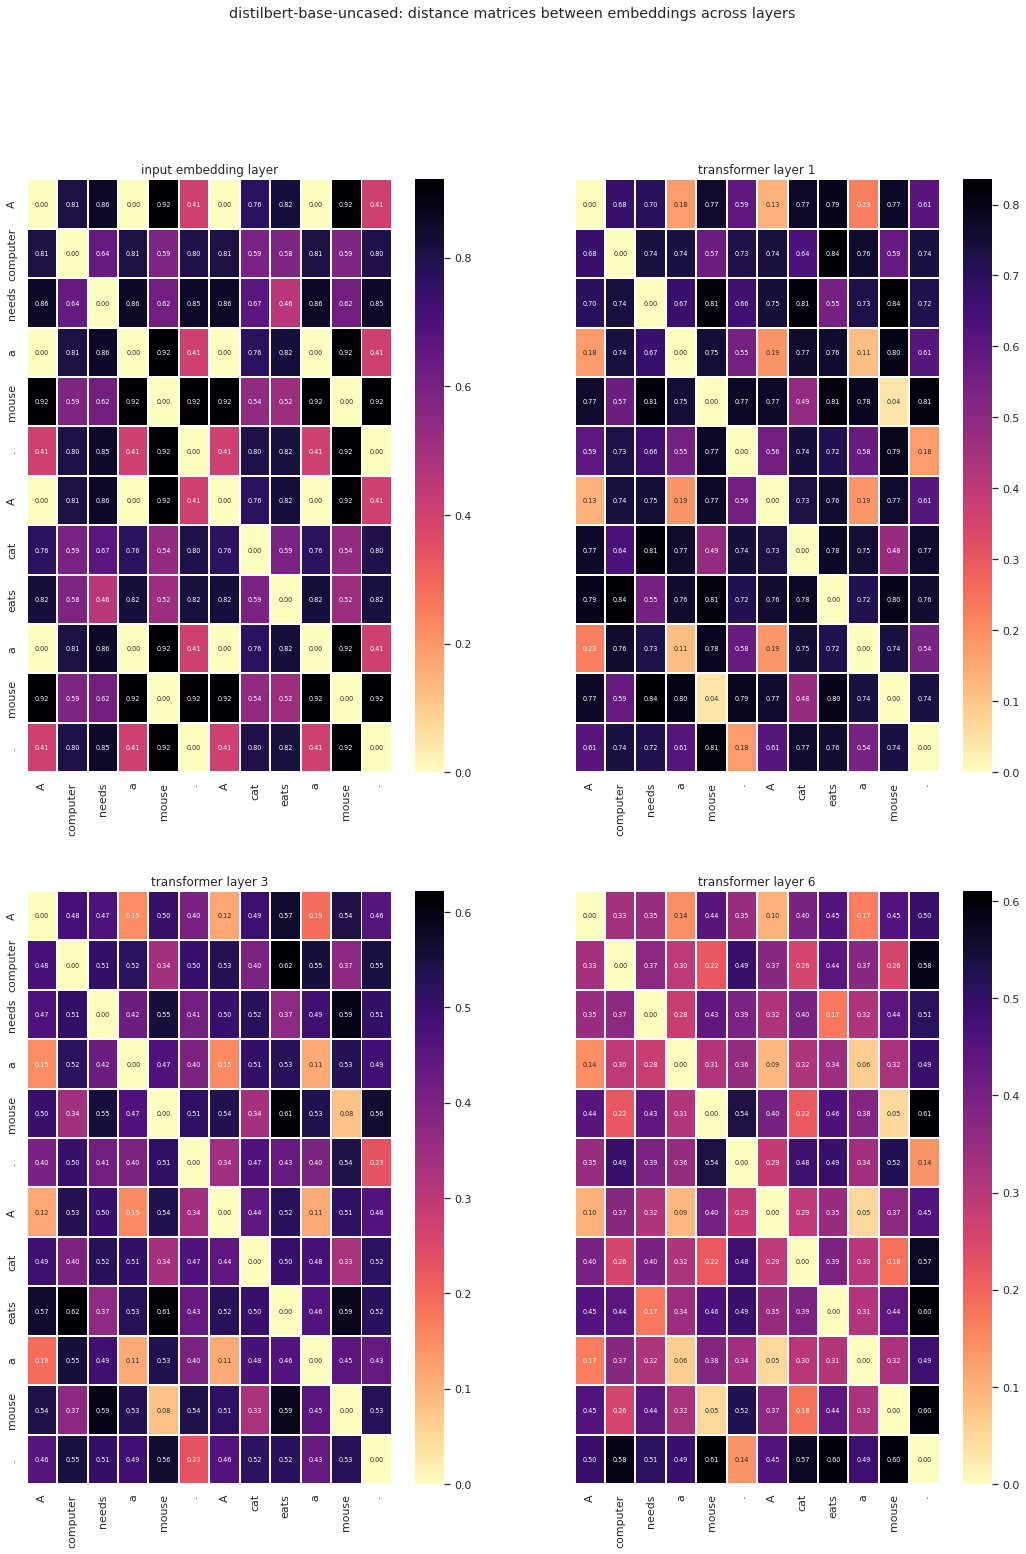

In [ ]:
# @title Plot distance matrices between word embeddings for different layers
model_name = 'distilbert-base-uncased' #model_name = 'DistilBERT'

labels = ["A", "computer", "needs","a","mouse",".","A","cat","eats","a","mouse","."]

plot_data = [
    ("xy", 0, "input embedding layer"),
    ("x", 1, "layer 1"),
    ("xy", 3, "layer 3"),
    ("x", 6, "layer 6"),
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 24))
fig.suptitle(model_name + ': distance matrices between embeddings across layers')

for subplot, (label_axes, matrix_index, title) in zip(itertools.chain.from_iterable(axes), plot_data):
    heatmap_args = dict(
        linewidth=1, 
        annot = np.array([[f"{v:.2f}" if (v == 0 or len(str(v)) > 4) 
        else f"{v:.1f}" for v in r] for r in distance_matrices[matrix_index]]),
        annot_kws={"size":6.5}, 
        fmt="",
        cmap = 'magma_r', 
        xticklabels=labels, 
        yticklabels=labels,
    )

    heatmap = sns.heatmap(distance_matrices[matrix_index], ax=subplot, **heatmap_args)
    subplot.set_title(title)
    for axis in [x for x in "xy" if x not in label_axes]:
        getattr(subplot, f"{axis}axis").set_visible(False)
plt.show()

In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 6</b></font> (1pt)
#@markdown Report the distances between computer and mouse1, and cat and mouse2 in layer 0 and layer 6. Explain briefly what is happening.
Response = "" #@param {type:"string"}

<font color='darkorange'>**ToDo**</font> 

Now that we have distance (disimilarity) matrices, we can quite straightforwardly run Representational Similarity Analysis, between layers of the Large Langauge Model. Try the following, starting by a somewhat larger piece of text, rerunning the **"retrieve activation vectors"** code above and then computer distance matrices and representational similarity.

In [ ]:
# input sentences for the model
sentences = [
    "Harry had never believed he would meet a boy he hated more than Dudley, but that was before he met Draco Malfoy.",
    "Still, first-year Gryffindors only had Potions with the Slytherins, so they didn't have to put up with Malfoy much.",
    "Or at least, they didn't until they spotted a notice pinned up in the Gryffindor common room that made them all groan."
           ]

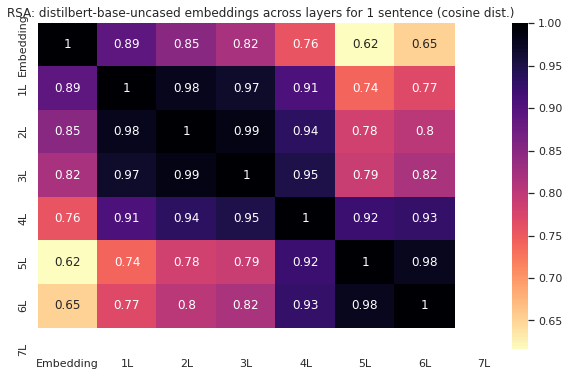

In [ ]:
distance_matrices_cosine = compute_distance_matrices(vecs, measure="cosine")
rsa_mat_cosine = RSA_matrix(distance_matrices_cosine, method='pearson')
plot_RSA(rsa_mat_cosine, model_name, dist_method="cosine")

In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 7</b></font> (1pt)
#@markdown Briefly describe the pattern you observe in the representational similarity between layers, and relate it to the layer-wise predictivity plot we saw in the Schrimpf et al. paper.
Response = "" #@param {type:"string"}

# Finetuning the language model on eye-tracking data


<font color='darkorange'>**ToDo**</font> 

Try fine-tuning the DistilBERT model on the eye tracking data for a few epochs using the code in the cell below. This can take a while (e.g. 30 minutes for 5 epochs). It's best to start with a low number of epochs (1 or 2). You can ignore the warning about the model checkpoint. After this cell has finished executing, your fine-tuned model should be saved to the _models_ folder within the _week4_ folder (check the File tab).

Alternatively, you **may also skip the cell below** and work with the models that you have added to your Google Drive at the start of this tutorial:
- A pre-trained, but not fine-tuned DistilBERT model (fine-tuned for 0 epochs), i.e. `distilbert_0_file`
- A fine-tuned DistilBERT model (trained for 150 epochs on the eye-tracking), i.e. `distilbert_150_file`

(If you choose the latter, proceed to the _Evaluating model predictions_ section below)

In [ ]:
# Note: 
# You could load any other BERT or DistilBERT model version available in the Huggingface library in the same manner. 
# DistilBERT was chosen for this tutorial since it has less parameters.

torch.set_grad_enabled(True)
random.seed(12345)
device = torch.device('cpu')
    
# define model
model_name = 'distilbert-base-uncased'
regr_model = TransformerRegressionModel(model_name).to(device)
train_data = EyeTrackingCSV(training_data, model_name=model_name)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
optimizer = torch.optim.AdamW(regr_model.parameters(), lr=5e-5)
loss = torch.nn.MSELoss()

# train model
# set num_epochs to 0 for no fine-tuning
num_epochs = 5
print("Starting training...")
for epoch in range(num_epochs):
    train(regr_model, train_loader, optimizer, loss)
    print("Epoch:", epoch)
print("Training done.")

# save model
output_model = './models/'+model_name+'_'+str(num_epochs)
torch.save(regr_model, output_model)
print("Model saved to", output_model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting training...
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Training done.
Model saved to ./models/distilbert-base-uncased_5


# Evaluating model predictions

We will now load a pre-trained model without fine-tuning, and a pre-trained model that is fine-tuned on eye tracking data, and see how well they do at predicting eye tracking features from text. When you run the cells below, you will see tables with the predictions for the different eye tracking features.

In [ ]:
# load pretrained model
model_name = 'distilbert_0'
pretrained_model_to_evaluate = distilbert_0_file

# if you want to load your own pretrained model (downloaded in the cell above), uncomment the lines below,
# change the filepath to the location of your model, and define your model's name (for saving the predictions file)
# note that this should be a model that is *not* finetuned (i.e. 0 epochs)
# pretrained_model_to_evaluate = 'models/distilbert-base-uncased_0'
# model_name = 'distilbert_0'

pretrained_model = torch.load(pretrained_model_to_evaluate)
predictions_pretrained = predict(pretrained_model, model_name, test_data)
predictions_pretrained

In [ ]:
# load model fine-tuned on eye-tracking data
model_name = 'distilbert_150'
finetuned_model_to_evaluate = distilbert_150_file

# if you want to load a model that you fine-tuned yourself, uncomment the lines below,
# change the filepath to the location of your model, and define your model's name (for saving the predictions file)
# finetuned_model_to_evaluate = 'models/distilbert-base-uncased_5'
# model_name = 'distilbert_5'

finetuned_model = torch.load(finetuned_model_to_evaluate)
predictions_finetuned = predict(finetuned_model, model_name, test_data)
predictions_finetuned

## Baseline

We also need a baseline to compare our models' performances against. We will use the mean central tendency as a baseline, i.e. our estimate for each eye tracking feature will be the mean value of that feature in the training data.

In [ ]:
# compute mean values from training file
features = ["nFix","FFD","GPT","TRT","fixProp"]
mean_feat_values = {}
print("Mean feature values in training data:")
for feat in features:
    avg = np.mean(training_data[feat])
    mean_feat_values[feat] = avg
    print (feat, avg)

# make dataframe of test data with mean values
mean_data = test_data.copy()
for feat in features:
    mean_data[feat] = mean_feat_values[feat]

Mean feature values in training data:
nFix 15.10177827483709
FFD 3.1910228250548047
GPT 6.345511205701235
TRT 5.309609916601226
fixProp 67.05723394392217


## Evaluation metric: Mean absolute error

Now that we have the predictions of the baseline (the mean values) as well as the predictions of the pre-trained and fine-tuned models, we can compare them on an evaluation metric. 

We will evaluate prediction performance by using the _mean absolute error_ metric (MAE), meaning that we average over the error of all samples in the test set:

$MAE = \frac{\sum_{i=1}^{n} | y_{i} - x_{i}|}{n} $




In [ ]:
# calculate mean absolute error on the predictions
print("Results pre-trained model:")
mae_pretrained = evaluate(predictions_pretrained, test_data)
print("Results fine-tuned model:")
mae_finetuned = evaluate(predictions_finetuned, test_data)
print("Results mean baseline:")
mae_mean = evaluate(mean_data, test_data)

data = pd.DataFrame(data={'results': ["mean", "pretrained", "finetuned"], 'mae': [mae_mean, mae_pretrained, mae_finetuned]})
ax = sns.barplot(x="results", y="mae", data=data, palette="flare")
ax.set_ylabel('MAE overall', fontsize=16)
plt.show()

<font color='limegreen'><b>Tip</b></font> If you are interested in seeing how good these results are compared to the systems participating in the CMCL Shared Task, have a look at Table 3 of [this paper](https://aclanthology.org/2021.cmcl-1.7.pdf).

As the numbers and the plot above should show, the pre-trained model that is not trained on eye-tracking features but purely on text, does not beat the mean baseline. However, the model fine-tuned on eye-tracking data is substantially better (i.e., lower MAE) than the baseline.

In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 8</b></font> (1pt)
#@markdown Is the difficulty of predicting individual eye-tracking features analogous in all models? Which feature is hardest to predict? Would you say the models are more capable of capturing early processing stages of lexical access or late-stage semantic integration? Which eye-tracking features illustrate this?
Response = "" #@param {type:"string"}

In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 9</b></font> (1pt)
#@markdown Compare the error scores for eye-tracking features across models to the overview of the training data (in the _Training data overview_ section above). Why do you think the error for the features representing reading times (FFD, GPT, TRT) is lower than the error for the other features (nFix and fixProp)? **(0.5pt)** Why might the fixProp feature be particularly difficult to predict? **(0.5pt)**
Response = "" #@param {type:"string"}

## Visualization of predictions
We can also visualize the predictions of different models, the baseline and the true data for specific sentences.

<font color='darkorange'>**Todo**</font> Compare the results for a few specific sentences and features (change the sentence_to_plot and feature_to_plot variables in the code cell below).

In [ ]:
# plot a sentence with real eye tracking data and the corresponding model predictions
sentence_to_plot = 953 # 801, 901, 950, 953
feature_to_plot = "FFD" # TRT, GPT, nFix, fixProp 

true_sentence = test_data.loc[test_data['sentence_id'] == sentence_to_plot]
predicted_sentence_finetuned = predictions_finetuned.loc[predictions_finetuned['sentence_id'] == sentence_to_plot]
predicted_sentence_pretrained = predictions_pretrained.loc[predictions_pretrained['sentence_id'] == sentence_to_plot]

# todo: change fig size accroding to sent length
fig, ax = plt.subplots(1,1,figsize=(len(true_sentence)*1.5,5))
ax.plot(list(range(len(true_sentence))), true_sentence[feature_to_plot], label="correct", color="blue", linestyle="--")
ax.plot(list(range(len(predicted_sentence_finetuned))), predicted_sentence_finetuned[feature_to_plot], label="fine-tuned", color="red", marker='o', ms=10, linestyle="-.")
ax.plot(list(range(len(predicted_sentence_pretrained))), predicted_sentence_pretrained[feature_to_plot], label="pretrained", color="pink", marker='o', ms=10, linestyle="-.")

# todo: add mean as a task
ax.plot(list(range(len(predicted_sentence_pretrained))), [mean_feat_values[feature_to_plot]]*len(predicted_sentence_pretrained), label="mean", color="lightblue", marker='o', ms=10, linestyle="--")

ax.set_ylabel(feature_to_plot, fontsize=16)
ax.set_xticks(list(range(len(true_sentence))))
ax.set_xticklabels(true_sentence['word'], fontsize=16)
ax.legend(fontsize=13)
plt.show()

## Part of Speech Analysis

Above, we have both evaluated the aggregated performance of the models as well as looked at the predictions for specific sentences. 

Next, we want to analyze whether there are certain word categories (i.e. parts of speech, PoS) for which eye tracking features are more easily predictable than others. Therefore, we first use a part-of-speech tagger to get the PoS tags for the sentence in our test data, and then plot the predictions vs. true eye tracking data per PoS tag below.

In [ ]:
# tag the data and add the tags to the dataframe
def pos_tag(data_to_tag):
    words = [str(w).replace("<EOS>", ".") for w in data_to_tag['word']]
    tagged_sents = nlp(words)
    data_to_tag['pos_tags'] = [token.pos_ for token in tagged_sents]
    return data_to_tag

tagged_data = pos_tag(test_data)
tagged_predictions = pos_tag(predictions_finetuned)

<font color='darkorange'>**Todo**</font> Compare the results for a few different features (change the feature_to_plot variable in the code cell below).

In [ ]:
feature_to_plot = "TRT"

#fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(x="pos_tags", y=feature_to_plot, data=tagged_data, color="green", label="true eye tracking data", alpha=0.4)
sns.barplot(x="pos_tags", y=feature_to_plot, data=tagged_predictions, color="red", label="predicted", alpha=0.4)
plt.legend()
plt.show()

<font color='limegreen'><b>Tip</b></font> To look up what the PoS tag abbreviations mean, you can use the `spacy.explain()` function as demonstrated below.

In [ ]:
spacy.explain('ADJ')

'adjective'

In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 10</b></font> (1pt)
#@markdown Can you think of any additional linguistic analyses that would be interesting to compare the models' performances on?
Response = "" #@param {type:"string"}